In [ ]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [1]:
import os
import zipfile 
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import re
import numpy as np
import torch

# os.environ["WANDB_MODE"] = "offline"

# import wandb
# wandb.login(key='')


class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None, num_domains=10):
        """
        Args:
          root_dir (string): Directory with all the images
          transform (callable, optional): transform to be applied to each image sample
        """
        # Read names of images in the root directory
        
        # Path to folder with the dataset
        if not os.path.isdir(root_dir):
            os.makedirs(root_dir)
        dataset_folder = f'{root_dir}/img_align_celeba/'
        self.dataset_folder = os.path.abspath(dataset_folder)

        image_names = os.listdir(self.dataset_folder)

        self.transform = transform 
        image_names = natsorted(image_names)
        
        self.filenames = []
        self.annotations = []
        with open(f'{root_dir}/list_attr_celeba.txt') as f:
            for i, line in enumerate(f.readlines()):
                line = re.sub(' *\n', '', line)
                if i == 0:
                    continue
                elif i == 1:
                    self.header = re.split(' +', line)
                else:
                    # values = re.split(' +', line)
                    # filename = values[0]
                    # self.filenames.append(filename)
                    # self.annotations.append([int(v) for v in values[1:num_domains]])
                    
                    values = re.split(' +', line)
                    val = [int(v) for v in values[1 : num_domains + 1]]
                    try:
                        index = val.index(1)
                    except:
                        continue
                    filename = values[0]
                    self.filenames.append(filename)
                    self.annotations.append(val)
                    
        self.annotations = np.array(self.annotations)    
              
    def __len__(self): 
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.dataset_folder, img_name)
        img_attributes = self.annotations[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, {'filename': img_name, 'idx': idx, 'attributes': torch.tensor(img_attributes).long()}
    

In [2]:
import torch
import torch.nn.functional as F
import lpips
from torchvision import transforms
from munch import Munch
import gc
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Munch()

args.num_domains = 10
args.img_size = 256
args.latent_dim = 16

args.num_iters = 1e5
args.batch_size = 8
args.lr = 1e-4
args.mapping_lr = 1e-6
args.betas = (0, 0.99)
args.lambda_style = 1.0
args.lambda_cycle = 1.0
args.lambda_ds = 1.0
args.gamma = 1.0
args.weight_decay = 1e-4 # i didn't find about this in a paper so took from github




transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

dataset = CelebADataset('celeba', transform=transform, num_domains=args.num_domains)


num_workers = 0 if device.type == 'cuda' else 2
pin_memory = True if device.type == 'cuda' else False


# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

## Визуализация датасетов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

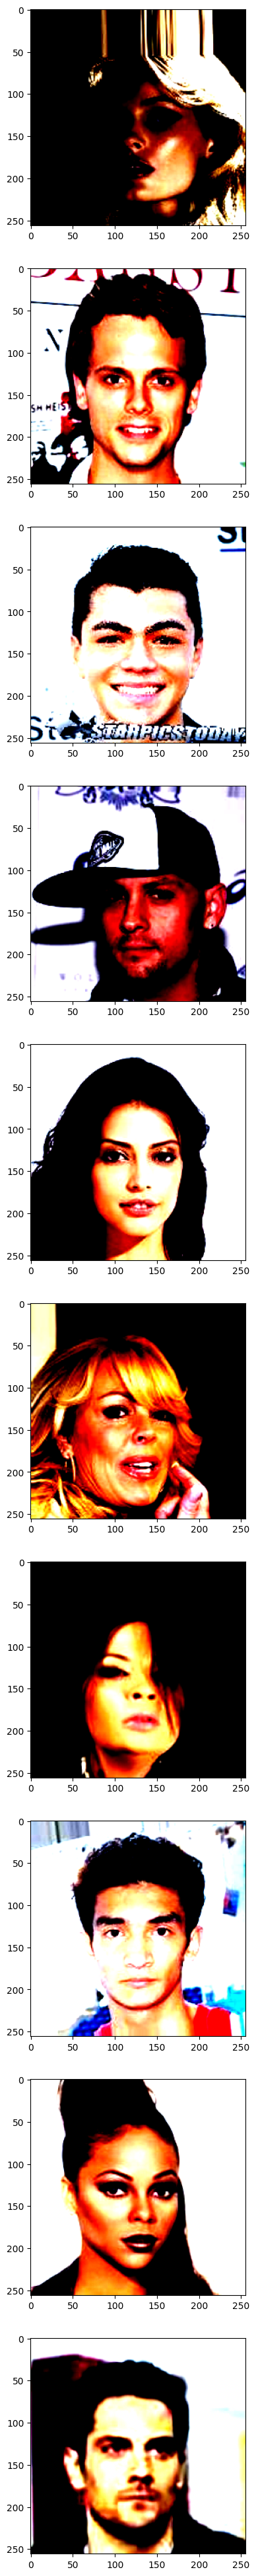

In [3]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))

# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](assets/stargan.png)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

In [4]:
domains = {
    0: '5_o_Clock_Shadow',
    1: 'Arched_Eyebrows',
    2: 'Attractive',
    3: 'Bags_Under_Eyes',
    4: 'Bald',
    5: 'Bangs',
    6: 'Big_Lips',
    7: 'Big_Nose',
    8: 'Black_Hair',
    9: 'Blond_Hair',
}

In [5]:
from PIL import Image

def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)  # [-1,1]  --> [0,1]
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

def parse_images(img, y_trg, gen_img, display_count=2):
    im_data = []

    display_count = min(display_count, len(img))
    for i in range(display_count):
        cur_im_data = {
            'input_image': tensor2im(img[i]),
            f'{domains[y_trg[i].item()]}': tensor2im(gen_img[i]),
        }
        im_data.append(cur_im_data)

    return im_data
    
    
def vis_faces(log_hooks1):
    display_count = len(log_hooks1)
    fig = plt.figure(figsize=(6 * 2, 4 * display_count))
    gs = fig.add_gridspec(display_count, 2)
    for i in range(display_count):
        hooks_dict1 = log_hooks1[i]

        fig.add_subplot(gs[i, 0])
        plt.imshow(hooks_dict1['input_image'])
        plt.title('input_image')

        fig.add_subplot(gs[i, 1])
        domain = list(hooks_dict1.keys())[1]
        plt.imshow(hooks_dict1[domain])
        plt.title(domain)

    plt.tight_layout()
    return fig

In [6]:
from torch import nn
import math
import torch.nn.functional as F


class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, normalize=False, downsample=False):
        super().__init__()
        self.actv = nn.GELU()
        self.normalize = normalize
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out)

    def _build_weights(self, dim_in, dim_out):
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1, bias=False)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2)  # unit variance


class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features * 2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta


class AdaInResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=64, upsample=False):
        super().__init__()
        self.actv = nn.GELU()
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out, style_dim)

    def _build_weights(self, dim_in, dim_out, style_dim=64):
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1, bias=False)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        out = self._residual(x, s)
        out = (out + self._shortcut(x)) / math.sqrt(2)
        return out


class Generator(nn.Module):
    def __init__(self, img_size=256, style_dim=64):
        super().__init__()
        n_block = int(math.log2(img_size)) - 4
        dim_in = 2 ** 14 // img_size
        self.conv1x1 = nn.Conv2d(3, dim_in, 1, bias=False)
        self.to_img = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 3, 1, bias=False)
        )
        max_dim = 512
        self.downsample_blocks = []
        self.upsample_blocks = []
        for i in range(n_block):
            self.downsample_blocks.append(ResBlock(dim_in, min(2 * dim_in, max_dim), normalize=True, downsample=True))
            self.upsample_blocks.append(AdaInResBlock(min(2 * dim_in, max_dim), dim_in, style_dim, upsample=True))
            dim_in = min(2 * dim_in, max_dim)
        for i in range(2):
            self.downsample_blocks.append(ResBlock(dim_in, dim_in, normalize=True))
            self.upsample_blocks.append(AdaInResBlock(dim_in, dim_in, style_dim), )
        self.downsample_blocks = nn.Sequential(*self.downsample_blocks)
        self.upsample_blocks = nn.Sequential(*self.upsample_blocks[::-1])

    def forward(self, x, s):
        out = self.conv1x1(x)
        out = self.downsample_blocks(out)
        for block in self.upsample_blocks:
            out = block(out, s)
        return self.to_img(out)

In [7]:
class MappingNetwork(nn.Module):
    def __init__(self, num_domain, style_dim=64, latent_dim=16):
        super().__init__()
        self.shared = [nn.Linear(latent_dim, 512), nn.GELU()]
        self.style_dim = style_dim
        for i in range(3):
            self.shared.extend([nn.Linear(512, 512), nn.GELU()])
        self.shared = nn.Sequential(*self.shared)
        self.unshared = nn.ModuleList()
        self.unshared = nn.Sequential(
            nn.Linear(512, num_domain * 512),
            nn.GELU(),
            nn.Linear(num_domain * 512, num_domain * 512),
            nn.GELU(),
            nn.Linear(num_domain * 512, num_domain * 512),
            nn.GELU(),
            nn.Linear(num_domain * 512, num_domain * style_dim),
        )

    def forward(self, z, y):
        out = self.shared(z)  #batch_size x 512
        out = self.unshared(out)  # batch_size x (num_domain * style_dim)
        out = torch.stack(out.split(self.style_dim, dim=1)) # num_domain x batch_size x style_dim
        return out[y, torch.arange(y.shape[0])]

In [8]:
class StyleEncoder(nn.Module):
    def __init__(self, num_domain, img_size=256, style_dim=64):
        super().__init__()
        dim_in = 2 ** 14 // img_size
        self.conv1x1 = nn.Conv2d(3, dim_in, 1, bias=False)
        n_block = int(math.log2(img_size)) - 2
        self.style_dim = style_dim
        self.layers = []
        for i in range(n_block):
            self.layers.append(ResBlock(dim_in, min(2 * dim_in, 512), downsample=True))
            dim_in = min(2 * dim_in, 512)
        self.layers.extend([
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, dim_in, 4, bias=False),
            nn.LeakyReLU(0.2)
        ])
        self.layers = nn.Sequential(*self.layers)
        self.fc = nn.Linear(dim_in, num_domain * style_dim)

    def forward(self, x, y):
        out = self.conv1x1(x)
        out = self.layers(out)
        out = out.view(out.size(0), -1)  # batch_size x 512
        out = self.fc(out)  # batch_size x (num_domain * style_dim)
        out = torch.stack(out.split(self.style_dim, dim=1)) # num_domain x batch_size x style_dim
        return out[y.squeeze(), torch.arange(y.shape[0])]


In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_domain, img_size=256):
        super().__init__()
        dim_in = 2 ** 14 // img_size
        self.conv1x1 = nn.Conv2d(3, dim_in, 1, bias=False)
        n_block = int(math.log2(img_size)) - 2
        self.num_domain = num_domain
        self.layers = []
        for i in range(n_block):
            self.layers.append(ResBlock(dim_in, min(2 * dim_in, 512), downsample=True))
            dim_in = min(2 * dim_in, 512)
        self.layers.extend([
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, dim_in, 4, bias=False),
            nn.LeakyReLU(0.2),
        ])
        self.layers = nn.Sequential(*self.layers)
        self.fc = nn.Linear(dim_in, num_domain)

    def forward(self, x, y):
        out = self.conv1x1(x)
        out = self.layers(out)
        out = out.view(out.size(0), -1)  # batch_size x 512
        out = self.fc(out)  # batch_size x num_domain
        return out[torch.arange(y.shape[0]), y.squeeze()]

In [10]:
nets = Munch()
nets.generator = Generator(args.img_size)
nets.mapping_network = MappingNetwork(args.num_domains, latent_dim=args.latent_dim)
nets.style_encoder = StyleEncoder(args.num_domains, args.img_size)
nets.discriminator = Discriminator(args.num_domains, args.img_size)

In [11]:
optimizers = Munch()
optimizers.generator = torch.optim.Adam(nets.generator.parameters(), lr=args.lr, betas=args.betas, weight_decay=args.weight_decay)
optimizers.mapping_network = torch.optim.Adam(nets.mapping_network.parameters(), lr=args.mapping_lr, betas=args.betas, weight_decay=args.weight_decay)
optimizers.style_encoder = torch.optim.Adam(nets.style_encoder.parameters(), lr=args.lr, betas=args.betas, weight_decay=args.weight_decay)
optimizers.discriminator = torch.optim.Adam(nets.discriminator.parameters(), lr=args.lr, betas=args.betas, weight_decay=args.weight_decay)

In [12]:
def adversarial_loss(logits, target):
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss


def r1_reg(out, x):
    batch_size = x.size(0)
    grad_dout = torch.autograd.grad(
        outputs=out.sum(), inputs=x,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

In [13]:
def compute_d_loss(nets, args, x_real, y_original, y_trg, x_ref=None, z=None):
    if (x_ref is not None) == (z is not None):
        raise ValueError('if x_ref is not None that z should be None and vica versa')
    x_real.requires_grad_()
    d_out_real = nets.discriminator(x_real, y_original)
    adv_loss_real = adversarial_loss(d_out_real, 1)
    r1_loss = r1_reg(d_out_real, x_real)
    with torch.no_grad():
        if x_ref is not None:
            style = nets.style_encoder(x_ref, y_trg)
        else:
            style = nets.mapping_network(z, y_trg)
        x_fake = nets.generator(x_real, style)

    d_out_fake = nets.discriminator(x_fake, y_trg)
    adv_loss_fake = adversarial_loss(d_out_fake, 0)

    loss = adv_loss_real + adv_loss_fake + args.gamma * r1_loss
    return loss, Munch(
        real=adv_loss_real.item(),
        fake=adv_loss_fake.item(),
        r1=r1_loss.item()
    )


def compute_g_loss(nets, args, x_real, y_original, y_trg, x_refs=None, zs=None, lambda_ds=0):
    if (x_refs is not None) == (zs is not None):
        raise ValueError('if x_ref is not None that z should be None and vica versa')

    if x_refs is not None:
        x_ref, x_ref2 = x_refs
    else:
        z, z2 = zs

    #############################################################################################
    #                                       adversarial loss                                    #
    #############################################################################################
    if x_refs is not None:
        style_trg = nets.style_encoder(x_ref, y_trg)
    else:
        style_trg = nets.mapping_network(z, y_trg)
    x_fake = nets.generator(x_real, style_trg)
    d_out = nets.discriminator(x_fake, y_trg)
    adv_loss = adversarial_loss(d_out, 1)

    #############################################################################################
    #                                           cycle loss                                      #
    #############################################################################################
    style_source = nets.style_encoder(x_real, y_original)
    cyc_loss = (torch.abs(x_real - nets.generator(x_fake, style_source))).mean()

    #############################################################################################
    #                                         diversity loss                                    #
    #############################################################################################
    if x_refs is not None:
        style_trg2 = nets.style_encoder(x_ref2, y_trg)
    else:
        style_trg2 = nets.mapping_network(z2, y_trg)

    x_fake2 = nets.generator(x_real, style_trg2)
    x_fake2 = x_fake2.detach()

    ds_loss = (torch.abs(x_fake - x_fake2)).mean()

    #############################################################################################
    #                                            style loss                                     #
    #############################################################################################

    style_trg_predict = nets.style_encoder(x_fake, y_trg)
    sty_loss = (torch.abs(style_trg - style_trg_predict)).mean()

    loss = adv_loss + args.lambda_style * sty_loss - lambda_ds * ds_loss + args.lambda_cycle * cyc_loss
    return loss, Munch(
        adv_loss=adv_loss.item(),
        sty_loss=sty_loss.item(),
        ds_loss=ds_loss.item(),
        cyc_loss=cyc_loss.item()
    )

In [14]:
def he_init(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)


def save_checkpoint(nets, optimizers, iteration):
    checkpoints = {
        'model': {
            'generator': nets.generator.state_dict(),
            'mapping_network': nets.mapping_network.state_dict(),
            'style_encoder': nets.style_encoder.state_dict(),
            'discriminator': nets.discriminator.state_dict()
        },
        'optimizer': {
            'generator': optimizers.generator.state_dict(),
            'mapping_network': optimizers.mapping_network.state_dict(),
            'style_encoder': optimizers.style_encoder.state_dict(),
            'discriminator': optimizers.discriminator.state_dict()
        },
        'iteration': iteration
    }
    torch.save(checkpoints, f'iteration{iteration}.pth')


def train(nets, args, optimizers, dataloader, checkpoints=None):
    for net in nets.values():
        net.apply(he_init)
    start_iter = 0
    if checkpoints is not None:
        print('Loading checkpoints...')
        checkpoint = torch.load(checkpoints)
        nets.generator.load_state_dict(checkpoint['model']['generator'])
        nets.mapping_network.load_state_dict(checkpoint['model']['mapping_network'])
        nets.style_encoder.load_state_dict(checkpoint['model']['style_encoder'])
        nets.discriminator.load_state_dict(checkpoint['model']['discriminator'])
        optimizers.generator.load_state_dict(checkpoint['optimizer']['generator'])
        optimizers.mapping_network.load_state_dict(checkpoint['optimizer']['mapping_network'])
        optimizers.style_encoder.load_state_dict(checkpoint['optimizer']['style_encoder'])
        optimizers.discriminator.load_state_dict(checkpoint['optimizer']['discriminator'])
        start_iter = checkpoint['iteration'] + 1
    for net in nets.values():
        net = net.to(device)
    lambda_ds = args.lambda_ds - args.lambda_ds / args.num_iters * start_iter
    for iteration in tqdm(range(start_iter, int(args.num_iters))):
        print(f'Iteration {iteration} / {int(args.num_iters)}')
        x_real, other = next(iter(dataloader))
        y_original = []
        for i in range(args.batch_size):
            y_original.append(other['attributes'][i].tolist().index(1))
        y_original = torch.tensor(y_original).long()
        x_ref, _ = next(iter(dataloader))
        x_ref2, _ = next(iter(dataloader))
        y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=args.batch_size)).long()
        z = torch.randn(args.batch_size, args.latent_dim)
        z2 = torch.randn(args.batch_size, args.latent_dim)

        x_real = x_real.to(device)
        y_original = y_original.to(device)
        x_ref = x_ref.to(device)
        x_ref2 = x_ref2.to(device)
        y_trg = y_trg.to(device)
        z = z.to(device)
        z2 = z2.to(device)

        #############################################################################################
        #                        Train discriminator using reference image                          #
        #############################################################################################

        optimizers.discriminator.zero_grad()
        d_loss, d_loss_ref = compute_d_loss(nets, args, x_real, y_original, y_trg, x_ref=x_ref)
        d_loss.backward()
        optimizers.discriminator.step()

        #############################################################################################
        #                        Train discriminator using latent vectors                           #
        #############################################################################################

        optimizers.discriminator.zero_grad()
        d_loss, d_loss_latent = compute_d_loss(nets, args, x_real, y_original, y_trg, z=z)
        d_loss.backward()
        optimizers.discriminator.step()

        #############################################################################################
        #                        Train other nets using reference image                             #
        #############################################################################################

        optimizers.generator.zero_grad()
        optimizers.mapping_network.zero_grad()
        optimizers.style_encoder.zero_grad()

        g_loss, g_loss_ref = compute_g_loss(nets, args, x_real, y_original, y_trg, x_refs=[x_ref, x_ref2],
                                            lambda_ds=lambda_ds)
        g_loss.backward()
        optimizers.generator.step()
        optimizers.mapping_network.step()
        optimizers.style_encoder.step()

        #############################################################################################
        #                        Train other nets using latent vectors                              #
        #############################################################################################

        optimizers.generator.zero_grad()
        optimizers.mapping_network.zero_grad()
        optimizers.style_encoder.zero_grad()

        g_loss, g_loss_latent = compute_g_loss(nets, args, x_real, y_original, y_trg, zs=[z, z2], lambda_ds=lambda_ds)
        g_loss.backward()
        optimizers.generator.step()
        optimizers.mapping_network.step()
        optimizers.style_encoder.step()

        if lambda_ds > 0:
            lambda_ds = args.lambda_ds - args.lambda_ds / args.num_iters * iteration
        if iteration % 5000 == 0:
            save_checkpoint(nets, optimizers, iteration)
        # if iteration % 1000 == 0 or (iteration < 1000 and iteration % 100 == 0):
            # with torch.no_grad():
                # z = torch.randn(2, 16).to(device)
                # y = torch.tensor(np.random.choice(np.arange(args.num_domains), size=2)).to(device)
                # style = nets.mapping_network(z, y)
                # x_fake = nets.generator(x_real[[0, 1],...], style)
                # fig = vis_faces(parse_images(x_real, y, x_fake))
                # fig.savefig(f'images/{iteration}.jpg')
                # plt.close(fig)
        #     wandb.log({f'images/{iteration}.jpg': wandb.Image(f'images/{iteration}.jpg')}, step=iteration)
        # if iteration % 100 == 0:
            # wandb.log({
            #     'G/ref_adv_loss': g_loss_ref.adv_loss,
            #     'G/ref_sty_loss': g_loss_ref.sty_loss,
            #     'G/ref_ds_loss': g_loss_ref.ds_loss,
            #     'G/ref_cyc_loss': g_loss_ref.cyc_loss,
            #     'G/lat_adv_loss': g_loss_latent.adv_loss,
            #     'G/lat_sty_loss': g_loss_latent.sty_loss,
            #     'G/lat_ds_loss': g_loss_latent.ds_loss,
            #     'G/lat_cyc_loss': g_loss_latent.cyc_loss,
            #     'D/ref_adv_loss_real': d_loss_ref.real,
            #     'D/ref_adv_loss_fake': d_loss_ref.fake,
            #     'D/ref_r1': d_loss_ref.r1,
            #     'D/lat_adv_loss_real': d_loss_latent.real,
            #     'D/lat_adv_loss_fake': d_loss_latent.fake,
            #     'D/lat_r1': d_loss_latent.r1,
            # }, step=iteration)


In [ ]:
# wandb.init(
#     project='StarGANv2',
#     entity='free001style',
#     name='second try',
#     config=args
#     )
train(nets, args, optimizers, dataloader)
# wandb.finish()

Графики лоссов лежат [тут](https://wandb.ai/free001style/StarGANv2?nw=nwuserfree001style)

# Evaluation

In [11]:
checkpoint = torch.load('iteration40000.pth')
nets.generator.load_state_dict(checkpoint['model']['generator'])
nets.mapping_network.load_state_dict(checkpoint['model']['mapping_network'])
nets.style_encoder.load_state_dict(checkpoint['model']['style_encoder'])
nets.discriminator.load_state_dict(checkpoint['model']['discriminator'])
for net in nets.values():
    net = net.to(device)

In [12]:
lpips_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/iadrobyshevskiy/.conda/envs/free001style/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
from tqdm.auto import trange
test_iters = 100
values = []
for i in trange(test_iters):
    print(i)
    # fetch images and labels
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    batch_size = x_real.shape[0]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # ваш домен
    
    x_real, x_ref = [x.to(device).float() for x in [x_real, x_ref]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    x_fake = nets.generator(x_real, nets.style_encoder(x_ref, y_trg))

    values.append(torch.mean(lpips_vgg(x_fake.cpu(), x_real.cpu()).squeeze()).item())

assert(np.mean(values) < 1.3)

In [14]:
np.mean(values)

0.5586452496051788

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


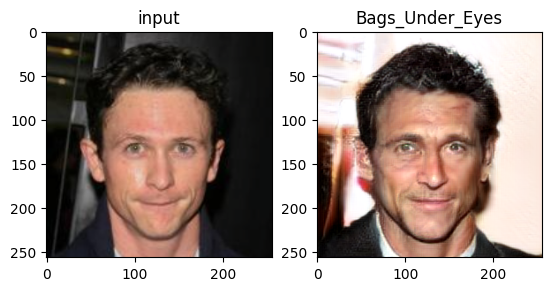

In [83]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
#     s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
i = 5
f, ax = plt.subplots(1, 2)
ax[0].imshow(invTrans(x_real[i]).permute(1,2,0).detach().cpu().numpy())
ax[1].imshow(invTrans(x_fake[i]).permute(1,2,0).detach().cpu().numpy())
ax[0].set_title('input')
ax[1].set_title(f'{domains[y_trg[i].item()]}')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


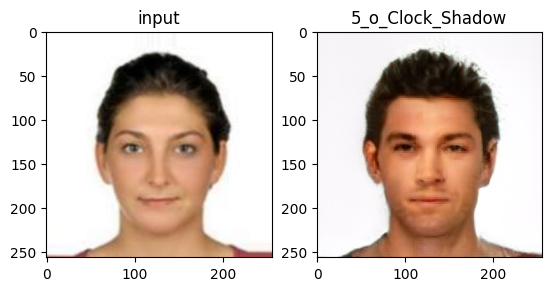

In [155]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
#     s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
i = 2
f, ax = plt.subplots(1, 2)
ax[0].imshow(invTrans(x_real[i]).permute(1,2,0).detach().cpu().numpy())
ax[1].imshow(invTrans(x_fake[i]).permute(1,2,0).detach().cpu().numpy())
ax[0].set_title('input')
ax[1].set_title(f'{domains[y_trg[i].item()]}')
plt.show()

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**

Посмотрим, насколько хорошо mapping network научилась мапить гауссовский шум с нужным доменом в стиль. Для этого воспользуемся TSNE

100%|██████████| 10/10 [00:00<00:00, 73.89it/s]


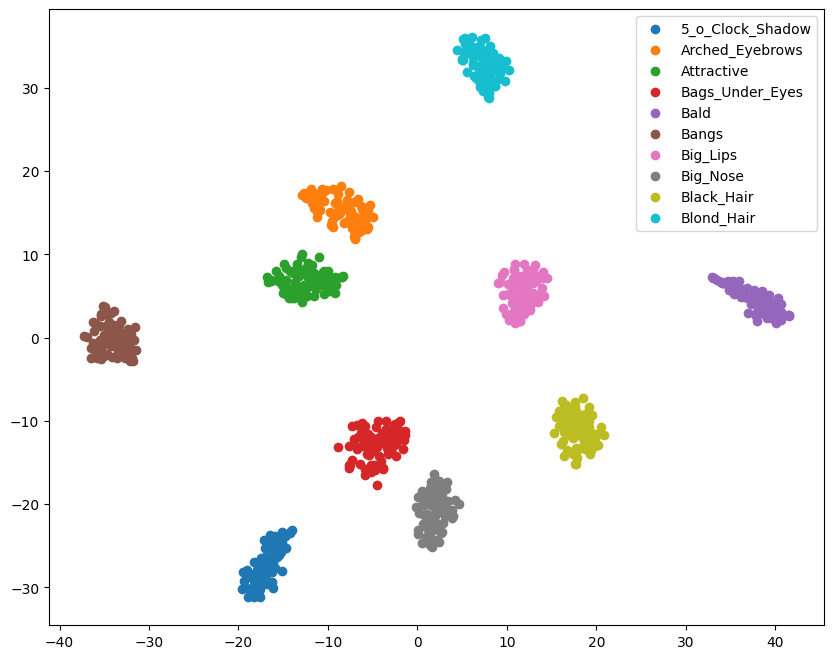

In [120]:
import tqdm
from sklearn.manifold import TSNE
z_s = torch.randn(80, args.latent_dim)

styles = []

for i in tqdm.tqdm(range(10)):
    for j in range(10):
        z = z_s[j * args.batch_size : (j + 1) * args.batch_size].to(device)
        y = torch.full((args.batch_size, ), i)
        styles.append(nets.mapping_network(z, y))

styles = torch.cat(styles, dim=0).detach().cpu().numpy()
assert styles.shape == (800, 64)
new_styles = TSNE().fit_transform(styles)

fig = plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(new_styles[i * 80: (i + 1) * 80, 0], new_styles[i * 80: (i + 1) * 80, 1], label=domains[i])
plt.legend()

Видно, что почти все кучки на достаточном расстоянии друг от друга, а значит полученные нами стили как минимум хорошо различаются. В то же время мы ничего не можем сказать о том, насколько хорошо эти стили получаются, мы просто знаем, что полученные вектора достаточно близки к друг другу в случае, если domain один, и далеки, если другой.

Насчёт визуально качетсвенного результата: выше я привёл в пример два изображения. Так же [тут](https://wandb.ai/free001style/StarGANv2?nw=nwuserfree001style) можно ознакомиться с примерами генерации для каждой тысячной итерации(да и в целом на лоссы посмотреть). [Тут](https://drive.google.com/file/d/1PRw_tqRFFG5fXwIusl7O7-jubE7aAVtv/view?usp=sharing) лежат чекпоинты для 40к итераций, так что если очень хочется, можно поиграться.

Теперь ревью решения: 

На самом деле писался код по большей часть с помощью гитхаба авторов; то есть я смотрел на какой-то блок в статье, далее пытался это написал, приходил в затуп, шёл в код и дописывал, опираясь на него. По сравнению с кодом авторов я выкинул FAN(на сколько я понял, это доп сетка, которая делает выравнивние лиц), не делал аккумуляцию на инференсе и вроде всё. Также в статье были реализации со свёртками 1х1, у авторов кое-где были свёртки 3х3.

Ещё пару моментов по реализации:
 
- Каждая фотка датасета может принадлежать к нескольким из 40 доменов. Я решил оставить лишь 10, потому что во-первых сложно выучиться на все 40, во-вторых я не придумал, как можно обрабатывать фотку, у которой несколько доменов. Поэтому я сделал следующее: я просто брал первые 10 доменов и выбирал из них первый (естественно, если фотка принадлежит хотя бы одному из них, иначе я эту фотку удалял). Про проблемы этого подхода и способы их решения я напишу далее. Я решил ничего не исправлять, потому что ресурсы ограничены, не очень хочется всё это переучивать.
- На каждой итерации авторы делали два шага дискриминатора(используя картинки для получения стиля и гауссовский шум), два шага гениратора и одни шаг остальных сеток. Обнаружил я это, только когда решил посмотреть код полностью. Зачем они это сделали -- вопрос. Но после моего предолжения делать два шага каждой сетки за одну итерацию, у одного студента обучение пошло заметно быстрее и качество улучшилось. Мб это просто совпадение).

Теперь про возможные улучшения:

Выше я писал, что брать первый из 10 доменов картинки -- это не лучшая идея. Проблема на самом деле очевидна: некоторые домены намного сильнее других. Что я подразумеваю под сильнее: пусть у нас есть картинка блондинки с большими губами(то есть 2 домена), домен blond_hair в данном случае будет играть намного большую роль(на самом деле домен женщина, но его почему-то нет в датасете). Один из способов решения: можно выбрать 10 самых сильных признаков, которые, конечно, пересекаются, но не очень сильно. Вот предлагаемый список: Black_Hair, Blond_Hair, Male, Bald, Bangs, Eyeglasses, Straight_Hair, Wavy_Hair, Young, Mustache.

Если пойти ещё дальше, то можно вообще выкинуть эти сетки и оставить только mapping_network. В качестве генератора взять предобученный StyleGANv2, а качестве Style_encdoer взять какой-нибудь предобученный encoder, который получает латентное представление картинки в $\mathcal{W}^{+}$, например PSP_encoder. Дискриминатор можно взять от StyleGANv2(тоже предобученный). Учить будем один только mapping_encoder на reconsruction loss и style loss. Тут опять же будет проблема с тем, что каждая картинка имеет несколько стилей, но кажется, что точно такая же ситуация у авторов. Так что надо искать решение.

P.S. $\mathcal{W}^{+}$ нам нужно для картинок высокого разрешения(1024х1024), тогда надо учиться на чём-то таком же. Если хочется поменьше, то можно переводить на в $\mathcal{W}^{+}$, а $\mathcal{W}$(можно для этого взять предобученный ArcFace). 

P.P.S. Также можно сделать [fine-tune первых K слоёв StyleGAN](https://arxiv.org/pdf/2211.14068.pdf), а оставшиеся учить с нуля. Теперь нужен будет ещё и непредобученный дискриминатор, и adversarial loss, мб даже id loss.